# Лабораторная работа 4 "Мультимодальные данные"

## Постановка задачи

Собрать и разметить мультимодальные данные (например, текст, звук, изображения) и разработать стратегию их интеграции для решения задачи машинного обучения.

- Соберите/доберите или найдите готовый датасет, чтобы дополнить ваш проект до мультимодальности
- Разметьте мультимодальные данные и сделайте связку данных, если она еще не сделана (т.е сформируйте мультимодальный датасет)
- Опишите принцип связки мультимодельных данных
- Проведите предварительную обработку данных (например, очистка текста, нормализация изображений).
- Сделайте EDA для этих данных
- Опишите возможные кейсы использования полученных мультимодальных данных. (где их можно использовать/какую модель построить и тд)ь и тд)

## Описание датасета

**Идея:**

Получить данные о продуктах и ценах на них в разных магазинах, для возможности поиска наиболее выгодных предложений.
Также предполагается извлечение дополнительных признаков из описания товаров и поддержка гибкого добавления новых источников (магазинов).

**Реализация:** 

Используется датасет из ЛР1 со скрапингом товаров в категории Сыр с сайтов магазинов Магнита и Пятерочки. В качестве мультимодальных данных выбраны изображения упаковок сыра. Они скачиваются с сайтов. Затем сохраняется табличка, содержащая соответствие названия товара, магазина, полного пути к изображению, эмбеддинга изображения и поля разметки - уровня привлекательности упаковки.

Стоит сразу заметить, что оценка уровня привлекательности упаковки - крайне субъективна. Для машинного обучения можно использовать как ее, так и эмбеддинг изображения, для предказания цены на товар.

Данные затем интегрируются по наименованию товара.

## Импорт библиотек

In [7]:
!pip install -q selenium psycopg2 matplotlib seaborn polars torchvision

In [102]:
from sqlalchemy import create_engine, Column, Float, String, Date, Boolean, Integer, LargeBinary
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

from selenium.webdriver.chrome.service import Service
from selenium import webdriver
from typing import Optional, Tuple, Dict

import torchvision.transforms as transforms

from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from rapidfuzz import fuzz
from datetime import date
from io import BytesIO
import seaborn as sns
from PIL import Image
import pandas as pd
import polars as pl
import numpy as np
import requests
import random
import time
import csv
import os
import re

## Конфигурация подключения к базе данных

In [10]:
Base = declarative_base()

DATABASE_URL = "postgresql+psycopg2://{username}:{password}@{host}:{port}/{db_name}".format(
    host=os.getenv("POSTGRES_HOST", "localhost"),
    port=os.getenv("POSTGRES_PORT", "5432"),
    db_name=os.getenv("POSTGRES_DB", "store_parser"),
    username=os.getenv("POSTGRES_USER", "postgres"),
    password=os.getenv("POSTGRES_PASSWORD", "123456"),

)

def init_db():
    engine = create_engine(DATABASE_URL)
    Base.metadata.create_all(engine)
    Session = sessionmaker(bind=engine)
    return Session()

C:\Users\admin\AppData\Local\Temp\ipykernel_8872\988954521.py:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


## Класс, соответствующий структуре таблицы в БД

In [82]:
class ProductImg(Base):
    __tablename__ = 'store_products_images'

    name          = Column(String, nullable=False, primary_key=True)
    img_local_url = Column(String)
    img_embedding = Column(LargeBinary)
    store         = Column(String, nullable=False, primary_key=True)

    __table_args__ = {'extend_existing': True}

    def __repr__(self):
        return f"<Product(name='{self.name}', price={self.price}, date_added={self.date_added}, store={self.store})>"

C:\Users\admin\AppData\Local\Temp\ipykernel_8872\4083865053.py:1: SAWarning: This declarative base already contains a class with the same class name and module name as __main__.ProductImg, and will be replaced in the string-lookup table.
  class ProductImg(Base):


## Абстрактный класс конфигураций скрапера магазина

In [14]:
class StoreImgScraper(ABC):
    def __init__(self):
        self.store_name = ""
        self.base_url = ""
        self.auth_url = None
        self.product_selector = ""
        self.name_selector = ""
        self.page_param = ""
        self.image_selector = ""  

    def get_url(self, page: int) -> str:
        return f"{self.base_url}{self.page_param}{page}"
        

## Конфигурации для скрапинга Пятерочки

In [16]:
class PyaterochkaScraper(StoreImgScraper):
    def __init__(self):
        super().__init__()
        self.store_name = "Пятерочка"
        self.base_url = "https://5ka.ru/catalog/syr--251C13095/"
        self.product_selector = lambda tag: tag.get('data-qa', '') and re.compile(r'product-card-\d+$').match(tag.get('data-qa', ''))
        self.name_selector = '.chakra-text.SdLEFc2B-.css-1jdqp4k'
        self.image_selector = 'div.rJ4RnZvZ-' 
        self.page_param = "?page="
        self.headers = {
            "Accept": "*/*",
            "Accept-Encoding": "gzip, deflate, br, zstd",
            "Accept-Language": "ru,en;q=0.9",
            "Cache-Control": "no-cache",
            "Connection": "keep-alive",
            "Host": "id.x5.ru",
            "Pragma": "no-cache",
            "Sec-Fetch-Dest": "empty",
            "Sec-Fetch-Mode": "cors",
            "Sec-Fetch-Site": "same-origin",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36",
            "sec-ch-ua": '"Not A(Brand";v="8", "Chromium";v="132"',
            "sec-ch-ua-mobile": "?0",
            "sec-ch-ua-platform": '"Windows"'
        }


## Конфигурации скрапера Магнита

In [18]:
class MagnitScraper(StoreImgScraper):
    def __init__(self):
        super().__init__()
        self.store_name = "Магнит"
        self.base_url = "https://magnit.ru/catalog/37741-syry_mm?shopCode=161924&shopType=1&page="
        self.product_selector = '.unit-catalog-product-preview'
        self.name_selector = '.unit-catalog-product-preview-title'
        self.image_selector = '.unit-catalog-product-preview-image img' 
        self.page_param = ""
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
            "Content-Type": "application/x-www-form-urlencoded",
        }
        self.data = {
            "element": "CityStore",
            "block": "toolBar",
            "city": "Санкт-Петербург г",
            "store_id": "161924",
        }

## Реализация обращения к сайтам и сбора данных

In [20]:
class ProductImgScraper:
    def __init__(self, store_scraper):
        self.store = store_scraper
        self.driver = self._setup_driver()
        self.csv_filename = f"{self.store.store_name}_img_products.csv"

    def _setup_driver(self):
        options = webdriver.ChromeOptions()
        options.add_argument("--headless")
        options.add_argument("--no-sandbox")
        options.add_argument("--disable-dev-shm-usage")
        options.add_argument(f"user-agent={self.store.headers['User-Agent']}")
        service = Service(executable_path="C:/Users/admin/Downloads/chromedriver-win64/chromedriver-win64/chromedriver.exe")
        return webdriver.Chrome(service=service, options=options)

    def _setup_magnit_store(self):
        """Настройка города и магазина для Магнита"""
        if isinstance(self.store, MagnitScraper):
            print("Настраиваем город и магазин для Магнита...")
            self.driver.get("https://magnit.ru/")
            time.sleep(2)

            # Устанавливаем cookies вручную для выбора магазина
            self.driver.add_cookie({"name": "store_id", "value": "161924"})
            self.driver.add_cookie({"name": "city", "value": "Санкт-Петербург г"})

            self.driver.refresh()
            time.sleep(1)

    def download_image(self, product_element: BeautifulSoup) -> str:
        """
        Скачивает изображение для конкретного продукта.
        Извлекает src и alt из HTML-элемента продукта.
        """
        base_dir = os.getcwd() 
        
        img_element = product_element.select_one(self.store.image_selector)
        
        if not img_element:
            return ""

        # Извлечение URL в зависимости от типа элемента
        if img_element.name == "img":
            image_url = img_element['src']
        else:  # Для Пятерочки (div с background-image)
            style = img_element.get('style', '')
            match = re.search(r'url\(["\']([^"\'\?]+)', style)
            image_url = match.group(1) if match else None
            # print(image_url)

        if not image_url:
            return ""
            
        alt_text = img_element.get('alt', '').strip()
        
        if not alt_text:
            name_element = product_element.select_one(self.store.name_selector)
            alt_text = name_element.text.strip() if name_element else "image"

        file_ext = os.path.splitext(image_url)[1].split('@')[0]  # Убираем @webp
        file_name = f"{alt_text}{file_ext}"

        store_folder = os.path.join(base_dir or "", self.store.store_name)
        os.makedirs(store_folder, exist_ok=True)
        
        file_path = os.path.join(store_folder, file_name)
        file_path = os.path.normpath(file_path)
        
        try:
            response = requests.get(image_url, stream=True)
            response.raise_for_status() 
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            return file_path
        except Exception as e:
            print(f"Ошибка загрузки {image_url}: {e}")
            return ""

    
    def scrape_to_csv(self):
        file_exists = os.path.isfile(self.csv_filename)

        with open(self.csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['name', 'img_local_url', 'store']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=';')

            if not file_exists:
                writer.writeheader()

            page = 1
            current_date = str(date.today())
            
            # Настройка для Магнита
            self._setup_magnit_store()
            
            seen_products = set()

            if file_exists:
                with open(self.csv_filename, 'r', encoding='utf-8') as f:
                    reader = csv.DictReader(f, delimiter=';')
                    for row in reader:
                        seen_products.add((row['name'], row['store']))
            
            while True:                
                url = self.store.get_url(page)
                print(f"Запрос страницы: {url}")
                self.driver.get(url)
                time.sleep(5) 

                soup = BeautifulSoup(self.driver.page_source, "html.parser")
                products = soup.find_all(self.store.product_selector) if callable(
                    self.store.product_selector) else soup.select(self.store.product_selector)

                print(f"Найдено элементов на странице: {len(products)}")
                if not products:
                    print("Товары не найдены или все страницы загружены!")
                    break

                new_products = 0
                for item in products:
                    try:
                        name_elem = item.select_one(self.store.name_selector)
                        name = name_elem.text.strip() if name_elem else None

                        image_path = self.download_image(item)
                        
                        product_key = (name, self.store.store_name)

                        if product_key in seen_products or name is None:
                            continue

                        seen_products.add(product_key)
                        product_dict = {
                            "name": name,
                            "img_local_url": image_path,
                            "store": self.store.store_name
                        }
                        writer.writerow(product_dict)
                        new_products += 1

                    except Exception as e:
                        print(f"Ошибка при парсинге товара: {e}")
                        continue

                print(f"Страница {page} загружена, новых товаров: {new_products}")
                if new_products == 0:
                    print("Новых товаров не найдено, завершаем.")
                    break

                page += 1 
                time.sleep(random.uniform(1, 3))

        self.driver.quit()
        print(f"Данные добавлены в {self.csv_filename}")

## Преобразование данных и запись в БД

In [22]:
csv_schema = {
    "name": pl.Utf8,
    "img_local_url": pl.Utf8,
    "store": pl.Utf8
}

In [98]:
def process_image(img_path: str):
    img = Image.open(img_path).convert('RGB')
    # print(img.getpixel((100,100)))
    # Уменьшение размера изображения для экономии памяти
    img = img.resize((64, 64))
    
    # Построчная обработка пикселей
    vector = []
    for y in range(64):
        for x in range(64):
            r, g, b = img.getpixel((x, y))  
            vector.extend([r / 255.0, g / 255.0, b / 255.0])  # Нормализация
    
    vector = np.array(vector, dtype=np.float16)
    norm = np.linalg.norm(vector)
    vector = (vector / norm) if norm > 0 else vector
    
    return vector.tobytes()

In [104]:
def bytea_to_float_array(byte_data):
    """Converts bytea to a NumPy float array."""
    if byte_data is None:  
        return None
    try:
        buffer = BytesIO(byte_data)
        return np.frombuffer(buffer.read(), dtype=np.float32)  
    except Exception as e:
        print(f"Error converting bytea to float array: {e}")
        return None

In [86]:
def process_csv_to_db(csv_filename: str, session) -> None:
    df = pd.read_csv(csv_filename, delimiter=';')
    
    df['img_embedding'] = df['img_local_url'].apply(
        lambda x: process_image(r'{}'.format(x))
    )    

    existing_products = {
        (row.name, row.store) 
         for row in session.query(ProductImg.name, ProductImg.store).all()
    }
    # print(existing_products)
    count = 0
    for _, row in df.iterrows():
        product_key = (row['name'], row['store'])
        # print(product_key)
        if product_key not in existing_products:
            product_db = ProductImg(
                name=row['name'],
                store=row['store'],
                img_local_url=row['img_local_url'] if pd.notna(row['img_local_url']) else None,  
                img_embedding=row['img_embedding'] if pd.notna(row['img_embedding']) else None 
            )
            session.add(product_db)
            count += 1
    session.commit()
    print(f"{count} строк из {csv_filename} обработаны и записаны в базу данных")

## Вызов скрапера Пятерочки и запись в CSV

In [28]:
pyaterochka_scraper = PyaterochkaScraper()
scraper = ProductImgScraper(pyaterochka_scraper)
scraper.scrape_to_csv()

Запрос страницы: https://5ka.ru/catalog/syr--251C13095/?page=1
Найдено элементов на странице: 12
Страница 1 загружена, новых товаров: 0
Новых товаров не найдено, завершаем.
Данные добавлены в Пятерочка_img_products.csv


## Вызов скрапера Магнита и запись в CSV

In [30]:
magnit_scraper = MagnitScraper()
scraper = ProductImgScraper(magnit_scraper)
scraper.scrape_to_csv()

Настраиваем город и магазин для Магнита...
Запрос страницы: https://magnit.ru/catalog/37741-syry_mm?shopCode=161924&shopType=1&page=1
Найдено элементов на странице: 33
Страница 1 загружена, новых товаров: 0
Новых товаров не найдено, завершаем.
Данные добавлены в Магнит_img_products.csv


## Проверка сохраненных данных

In [32]:
pyaterochka_df = pl.read_csv("Пятерочка_img_products.csv", separator=';', schema=csv_schema, try_parse_dates=True)
print("Пятерочка:", len(pyaterochka_df))
print("\nПример данных из Пятерочки (последние записи):")
pyaterochka_df.tail()

Пятерочка: 122

Пример данных из Пятерочки (последние записи):


name,img_local_url,store
str,str,str
"""Сыр Верещагин Белпер Кнолле в …","""C:\Users\admin\Desktop\Learnin…","""Пятерочка"""
"""Сыр Верещагин Верещагинский по…","""C:\Users\admin\Desktop\Learnin…","""Пятерочка"""
"""Сыр Верещагин Конаковский с па…","""C:\Users\admin\Desktop\Learnin…","""Пятерочка"""
"""Сыр Белебеевский Благородный Д…","""C:\Users\admin\Desktop\Learnin…","""Пятерочка"""
"""Сыр Ларец с лисичками нарезка …","""C:\Users\admin\Desktop\Learnin…","""Пятерочка"""


In [33]:
magnit_df = pl.read_csv("Магнит_img_products.csv", separator=';', schema=csv_schema, try_parse_dates=True)
print("Магнит:", len(magnit_df))
print("\nПример данных из Магнита (последние записи):")
magnit_df.tail()

Магнит: 93

Пример данных из Магнита (последние записи):


name,img_local_url,store
str,str,str
"""Сыр плавленый Viola Сливочный …","""C:\Users\admin\Desktop\Learnin…","""Магнит"""
"""Сыр плавленый Viola Cливочный …","""C:\Users\admin\Desktop\Learnin…","""Магнит"""
"""Сыр Laime Пармезан выдержанный…","""C:\Users\admin\Desktop\Learnin…","""Магнит"""
"""Сыр Экомилк творожный 60% 350г""","""C:\Users\admin\Desktop\Learnin…","""Магнит"""
"""Сыр Василеостровская сыроварня…","""C:\Users\admin\Desktop\Learnin…","""Магнит"""


## Инициализация БД

In [84]:
session = init_db()

## Сохранение данных Пятерочки в БД

In [94]:
session.rollback()

In [88]:
process_csv_to_db("Пятерочка_img_products.csv", session)

122 строк из Пятерочка_img_products.csv обработаны и записаны в базу данных


In [114]:
# Определение схемы данных
load_schema = {
    "name": pl.Utf8,
    "img_local_url": pl.Float64,
    "img_embedding": pl.List(pl.Float32),
    "store": pl.Utf8
}

## Сохранение данных Магнита в БД

In [100]:
process_csv_to_db("Магнит_img_products.csv", session)

93 строк из Магнит_img_products.csv обработаны и записаны в базу данных


## Получение всех данных

In [339]:
results = (
    session.query(ProductImg)
    .all()
)

embeddings = [
    np.frombuffer(row.img_embedding, dtype=np.float32).tolist() 
    for row in results
]

data = [{
    "name": product.name,
    "img_local_url": product.img_local_url,
    "img_embedding": embeddings[i],
    "store": product.store
} for i, product in enumerate(results)]

df = pl.DataFrame(data).with_columns(
    pl.col("img_embedding").cast(pl.List(pl.Float32)).alias('img_embedding') 
)

df = pl.DataFrame(data)
pl.Config.set_fmt_str_lengths(200)
df.tail()

name,img_local_url,img_embedding,store
str,str,list[f64],str
"""Сыр плавленый Viola Сливочный 45% 130г""","""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Магнит\Сыр плавленый Viola Сливочный 45% 130г.jpeg""","[7.5600e-19, 7.5600e-19, … 7.5600e-19]","""Магнит"""
"""Сыр плавленый Viola Cливочный 45% 140г""","""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Магнит\Сыр плавленый Viola Cливочный 45% 140г.png""","[0.0, 0.0, … 1.4094e-20]","""Магнит"""
"""Сыр Laime Пармезан выдержанный 40% весовой""","""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Магнит\Сыр Laime Пармезан выдержанный 40% весовой.png""","[8.4746e-19, 3.7930e-20, … 1.6088e-21]","""Магнит"""
"""Сыр Экомилк творожный 60% 350г""","""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Магнит\Сыр Экомилк творожный 60% 350г.jpeg""","[1.3968e-18, 1.3968e-18, … 1.3968e-18]","""Магнит"""
"""Сыр Василеостровская сыроварня Пряди домашний с паприкой 45% 100г""","""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Магнит\Сыр Василеостровская сыроварня Пряди домашний с паприкой 45% 100г.jpeg""","[4.6461e-19, 4.6461e-19, … 4.6461e-19]","""Магнит"""


In [94]:
session.close()

## Пример изображений

Сыр Фетакса без рассола 45% БЗМЖ 200г


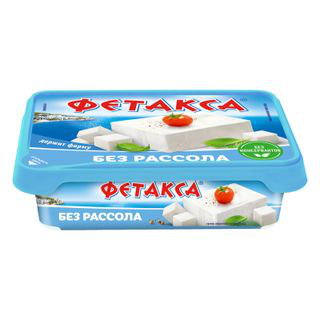

In [155]:
print(df.select('name').head(1).item(0,0))

img = Image.open(df.select('img_local_url').head(1).item(0, 0))
img

## Разметка изображений

Изображения упаковок сыра можно разметить на предмет привлекательности для клиента. Возможный вариант разметки - по шкале от 1 до 5, где
1 - точно не куплю
2 - скорее всего не куплю
3 - не уверен
4 - скорее всего куплю
5 - нравится, куплю

Разметка ручная. Ее удобно реализовать, отметив в свойствах изображений Оценку и распарсив эти метаданные библиотекой Pillow.

In [244]:
def get_rating(image_path):
    """Читает Windows-рейтинг из JPG."""
    try:
        img = Image.open(image_path)
        info = img._getexif()
        if info:
            rating = info.get(18246) 
            return rating
        else:
            return None
    except FileNotFoundError:
        return -1
    except Exception as e:
        return -1

In [246]:
print(get_rating(r"C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Пятерочка\Сыр плавленый Карат Дружба 45% БЗМЖ 90г.jpeg"))

1


Замена jpeg на jpg для Магнита (пришлось делать Save As для изображений Магнита из-за кривого формата, не позволяющего менять метаданные)

In [341]:
df = (
    df
    .with_columns(
        pl.when(pl.col('store') == 'Магнит')
        .then(pl.col('img_local_url').str.replace('.jpeg', '.jpg').str.replace('.png', '.jpg'))
        .otherwise(pl.col('img_local_url'))
        .alias('img_local_url')
    )
)

In [343]:
df_marked = df.with_columns(
    pl.col("img_local_url").map_elements(lambda x: get_rating(x), return_dtype=pl.Int32).alias("img_rating")
)

df_marked.sample(5)

name,img_local_url,img_embedding,store,img_rating
str,str,list[f64],str,i32
"""Сыр Радость Вкуса Топленое молочко нарезка 45% БЗМЖ 125г""","""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Пятерочка\Сыр Радость Вкуса Топленое молочко нарезка 45% БЗМЖ 125г.jpeg""","[2.1271e-19, 1.7883e-19, … 4.2802e-20]","""Пятерочка""",2
"""Сыр Сыробогатов Швейцарский 45% БЗМЖ 180г""","""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Пятерочка\Сыр Сыробогатов Швейцарский 45% БЗМЖ 180г.jpeg""","[1.6352e-21, 7.6145e-22, … 4.8881e-24]","""Пятерочка""",3
"""Сыр творожный Almette сливочный 60% БЗМЖ 150г""","""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Пятерочка\Сыр творожный Almette сливочный 60% БЗМЖ 150г.jpeg""","[9.0891e-19, 9.0891e-19, … 9.0891e-19]","""Пятерочка""",3
"""Сыр Брест-Литовск Российский 50% 150г""","""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Магнит\Сыр Брест-Литовск Российский 50% 150г.jpg""","[5.8997e-19, 5.8997e-19, … 5.8997e-19]","""Магнит""",3
"""Сыр Умалат Сулугуни молодой слоистый 45% БЗМЖ 200г""","""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Пятерочка\Сыр Умалат Сулугуни молодой слоистый 45% БЗМЖ 200г.jpeg""","[3.6358e-18, 1.3890e-17, … 9.4956e-19]","""Пятерочка""",4


Проверка на некорректные пуути к изображениям

In [314]:
df_marked.filter(pl.col('rating_value') == -1)

name,img_local_url,img_embedding,store,rating_value
str,str,list[f64],str,i32


## Интеграция с основным датасетом

### Конфигурация подключения к базе данных

In [319]:
Base = declarative_base()

DATABASE_URL = "postgresql+psycopg2://{username}:{password}@{host}:{port}/{db_name}".format(
    host=os.getenv("POSTGRES_HOST", "localhost"),
    port=os.getenv("POSTGRES_PORT", "5432"),
    db_name=os.getenv("POSTGRES_DB", "store_parser"),
    username=os.getenv("POSTGRES_USER", "postgres"),
    password=os.getenv("POSTGRES_PASSWORD", "123456"),

)

def init_db():
    engine = create_engine(DATABASE_URL)
    Base.metadata.create_all(engine)
    Session = sessionmaker(bind=engine)
    return Session()

C:\Users\admin\AppData\Local\Temp\ipykernel_8872\988954521.py:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


### Класс, соответствующий структуре таблицы в БД

In [322]:
class Product(Base):
    __tablename__ = 'store_products'

    name        = Column(String, nullable=False, primary_key=True)
    brand       = Column(String)
    price       = Column(Float)  
    weight      = Column(Float)
    unit        = Column(String)
    fat_content = Column(Float, nullable=True)
    is_sliced   = Column(Boolean, nullable=True)
    is_bzmj     = Column(Boolean, nullable=True)
    is_creamy   = Column(Boolean, nullable=True)
    discount    = Column(Float, nullable=True) 
    rating      = Column(Float, nullable=True)
    date_added  = Column(Date, default=date.today, primary_key=True)  
    store       = Column(String, nullable=False, primary_key=True)

    __table_args__ = {'extend_existing': True}

    def __repr__(self):
        return f"<Product(name='{self.name}', price={self.price}, date_added={self.date_added}, store={self.store})>"

### Чтение из БД

In [327]:
# Определение схемы данных
load_schema = {
    "name": pl.Utf8,
    "price": pl.Float64,
    "date_added": pl.Date,
    "store": pl.Utf8,
    "brand": pl.Utf8,
    "weight": pl.Float32,
    "unit": pl.Utf8,
    "fat_content": pl.Float32,
    "is_sliced": pl.Boolean,
    "is_bzmj": pl.Boolean,
    "is_creamy": pl.Boolean,
    "discount": pl.Float32,
    "rating": pl.Float32
}

In [345]:
results = (
    session
    .query(Product)
    .order_by(Product.date_added.asc())
    .all()
)

data = [{
    "name": product.name,
    "price": product.price,
    "date_added": product.date_added,
    "store": product.store,
    "brand": product.brand,
    "weight": product.weight,
    "unit": product.unit,
    "fat_content": product.fat_content,
    "is_sliced": product.is_sliced,
    "is_bzmj": product.is_bzmj,
    "discount": product.discount,
    "rating": product.rating
} for product in results]

df_main = pl.DataFrame(data, schema=load_schema)
df_main.sample(5)

name,price,date_added,store,brand,weight,unit,fat_content,is_sliced,is_bzmj,is_creamy,discount,rating
str,f64,date,str,str,f32,str,f32,bool,bool,bool,f32,f32
"""Сыр Брест-Литовск Маасдам 45% 200г""",269.99,2025-04-04,"""Магнит""","""Брест-Литовск Маасдам""",200.0,"""г""",45.0,null,null,null,null,4.7
"""Сыр Ларец с грецкими орехами 45% БЗМЖ 245г""",269.99,2025-03-29,"""Пятерочка""","""Ларец""",245.0,"""г""",45.0,null,true,null,null,4.91
"""Сыр плавленый Viola Cливочный 45% 140г""",139.99,2025-04-09,"""Магнит""","""Viola Cливочный""",140.0,"""г""",45.0,null,null,null,0.0,4.7
"""Сыр плавленый President с ветчиной 45% 400г""",269.99,2025-04-04,"""Магнит""","""President""",400.0,"""г""",45.0,null,null,null,22.0,4.8
"""Сыр творожный Pretto с травами 65% 140г""",114.99,2025-04-06,"""Магнит""","""Pretto""",140.0,"""г""",65.0,null,null,null,36.0,4.8


In [349]:
df_joined = (
    df_main.join(df_marked.drop('store'), on='name', how='left')
)
df_joined.sample(5)

name,price,date_added,store,brand,weight,unit,fat_content,is_sliced,is_bzmj,is_creamy,discount,rating,img_local_url,img_embedding,img_rating
str,f64,date,str,str,f32,str,f32,bool,bool,bool,f32,f32,str,list[f64],i32
"""Продукт рассольный Сиртаки Original 55% 200г""",149.99,2025-04-06,"""Магнит""","""Сиртаки Original""",200.0,"""г""",55.0,null,null,null,0.0,4.8,"""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Магнит\Продукт рассольный Сиртаки Original 55% 200г.jpg""","[1.3181e-17, 1.3181e-17, … 1.3181e-17]",3
"""Сыр Laplandia Edam нарезка 45% БЗМЖ 120г""",197.99,2025-04-11,"""Пятерочка""","""Laplandia Edam""",120.0,"""г""",45.0,true,true,null,0.0,4.92,null,null,null
"""Сыр Hochland Грюнландер полутвердый 50% БЗМЖ 400г""",409.99,2025-04-06,"""Пятерочка""","""Hochland Грюнландер""",400.0,"""г""",50.0,null,true,null,10.0,4.92,"""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Пятерочка\Сыр Hochland Грюнландер полутвердый 50% БЗМЖ 400г.jpeg""","[4.3947e-18, 4.3947e-18, … 4.3947e-18]",4
"""Сыр Поставы Городок Голландский премиум нарезка 45% 150г""",169.99,2025-03-29,"""Магнит""","""Поставы Городок Голландский""",150.0,"""г""",45.0,true,null,null,null,4.7,"""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Магнит\Сыр Поставы Городок Голландский премиум нарезка 45% 150г.jpg""","[9.9022e-19, 9.9022e-19, … 9.9022e-19]",2
"""Сыр ЭкоНива Momente aus Schollbrunn полутвердый 50% 200г""",199.99,2025-04-04,"""Магнит""","""ЭкоНива Momente""",200.0,"""г""",50.0,null,null,null,13.0,4.7,"""C:\Users\admin\Desktop\Learning\Magister\Semester_2\Data EDA\lab1\Магнит\Сыр ЭкоНива Momente aus Schollbrunn полутвердый 50% 200г.jpg""","[1.0580e-18, 1.0580e-18, … 1.0580e-18]",4


Мультимодальные данные можно использовать для предсказания стоимости товара. Эмбеддинг изображения добавляет информацию о привлекательности.
Для предсказания стоимости товара можно использовать градиентый бустинг.